In [175]:
%matplotlib inline
%config IPCompleter.greedy=True

import string
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Layer, Dropout
from tensorflow.keras.optimizers import Adam,Nadam,SGD
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import losses
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

from keras.constraints import maxnorm
from keras.preprocessing.text import Tokenizer

import nltk
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

In [176]:
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [177]:
test = pd.read_csv("../input/nlp-getting-started/test.csv")
train = pd.read_csv("../input/nlp-getting-started/train.csv")


In [178]:
train.describe, test.describe

(<bound method NDFrame.describe of          id keyword location  \
 0         1     NaN      NaN   
 1         4     NaN      NaN   
 2         5     NaN      NaN   
 3         6     NaN      NaN   
 4         7     NaN      NaN   
 ...     ...     ...      ...   
 7608  10869     NaN      NaN   
 7609  10870     NaN      NaN   
 7610  10871     NaN      NaN   
 7611  10872     NaN      NaN   
 7612  10873     NaN      NaN   
 
                                                    text  target  
 0     Our Deeds are the Reason of this #earthquake M...       1  
 1                Forest fire near La Ronge Sask. Canada       1  
 2     All residents asked to 'shelter in place' are ...       1  
 3     13,000 people receive #wildfires evacuation or...       1  
 4     Just got sent this photo from Ruby #Alaska as ...       1  
 ...                                                 ...     ...  
 7608  Two giant cranes holding a bridge collapse int...       1  
 7609  @aria_ahrary @TheTawniest

# Cleaing the Data

In [179]:
def remove_whitespace(data):
    return data.strip()

In [180]:
def remove_URL(data):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',data)

In [181]:
def remove_html(data):
    html=re.compile(r'<.*?>')
    return html.sub(r'',data)

In [182]:
def remove_emoji(data):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', data)

In [183]:
def remove_accented_chars(data):
    return unicodedata.normalize('NFKD', data).encode('ascii', 'ignore').decode('utf-8', 'ignore')

In [184]:
def remove_punctuation(data):
    table=str.maketrans('','',string.punctuation)
    return data.translate(table)

In [185]:
def single_char(data):
    new_data=''
    for w in data:
        print(w)
        if len(w) > 1:
            print(w)
            new_data = new_data +  " " + w
    
    return new_data

In [186]:
def remove_special_characters(data, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    data = re.sub(pattern, '', data)
    return data

In [187]:
def convert_lower_case(data):
    return data.lower()

In [188]:
def tokenise(data):
    data = word_tokenize(data)
    return data

In [189]:
def remove_stop_words(data):
    filtered_sentence = [w for w in data if not w in stop_words] 
    return filtered_sentence

In [190]:
def stemming(data):
    data.apply(lambda x: [stemmer.stem(e) for e in x])
    return data

In [191]:
def lemmatise(data):
    lemmatizer = WordNetLemmatizer()
    data.apply(lambda x: [lemmatizer.lemmatize(e) for e in x])
    return data 

In [192]:
def nlp_clean(data):
    data = remove_URL(data)
    data = remove_html(data)
    data = remove_emoji(data)
    data = remove_whitespace(data)    
    data = remove_accented_chars(data) 
    data = remove_special_characters(data)
    data = remove_punctuation(data)
    data = convert_lower_case(data)
    return data
    
def nlp_tokenise(data):
    stop_words = set(stopwords.words('english'))
    data = tokenise(data)
    data = remove_stop_words(data)
    return data
     
def nlp_normalise(data):
    stemmer = SnowballStemmer("english")
    data = stemming(data)
    data = lemmatise(data)
    return data

In [193]:
# Run preprossing steps to clean data
train['text']=train['text'].apply(lambda x : nlp_clean(x))
test['text']=test['text'].apply(lambda x : nlp_clean(x))

In [194]:
# Run steps to remove stop words
train['text']=train['text'].apply(lambda x : nlp_tokenise(x))
test['text']=test['text'].apply(lambda x : nlp_tokenise(x))

In [195]:
# rejoin Data after tokenisation 
def combine_text(list_of_text):
    combined_text = ''
    for word in list_of_text:
        combined_text = combined_text + ' ' + word
    return combined_text

In [196]:
train['text'] = train['text'].apply(lambda x : combine_text(x))
test['text'] = test['text'].apply(lambda x : combine_text(x))

In [197]:
train['text'].head(30)

0          deeds reason earthquake may allah forgive us
1                 forest fire near la ronge sask canada
2      residents asked shelter place notified office...
3      13000 people receive wildfires evacuation ord...
4      got sent photo ruby alaska smoke wildfires po...
5      rockyfire update california hwy 20 closed dir...
6      flood disaster heavy rain causes flash floodi...
7                            im top hill see fire woods
8      theres emergency evacuation happening buildin...
9                         im afraid tornado coming area
10                      three people died heat wave far
11     haha south tampa getting flooded hah wait sec...
12     raining flooding florida tampabay tampa 18 19...
13                      flood bago myanmar arrived bago
14        damage school bus 80 multi car crash breaking
15                                            whats man
16                                          love fruits
17                                        summer

In [198]:
test['text'].head(30)

0                           happened terrible car crash
1      heard earthquake different cities stay safe e...
2      forest fire spot pond geese fleeing across st...
3                 apocalypse lighting spokane wildfires
4                typhoon soudelor kills 28 china taiwan
5                                 shakingits earthquake
6      theyd probably still show life arsenal yester...
7                                                   hey
8                                              nice hat
9                                                  fuck
10                                       dont like cold
11                                      nooooooooo dont
12                                            dont tell
13                                                     
14                                              awesome
15     birmingham wholesale market ablaze bbc news f...
16               sunkxssedharry wear shorts race ablaze
17     previouslyondoyintv toke makinwauas marri

In [199]:
# train.to_csv('../../Data/NLPNovice/DSKtrain.csv', index=False)
# test.to_csv('../../Data/NLPNovice/DSKtest.csv', index=False)

# Load pre cleaned text files

In [200]:
# Load pre cleaned text files
# train = pd.read_csv('../../Data/NLPNovice/DSKtrain.csv')
# test = pd.read_csv('../../Data/NLPNovice/DSKtest.csv')

# # Convert text column from object to string
# train['text'] = train['text'].apply(lambda x : str(x))
# test['text'] = test['text'].apply(lambda x : str(x))

# Basic Model preperation

In [227]:
X_train, X_test, y_train, y_test = train_test_split(
            train['text'], train['target'], test_size=0.2, random_state=1000)

## Define word embedding

In [228]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [229]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
validation = tokenizer.texts_to_sequences(test['text'])

encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)
                                      
embedding_dim = 100
embedding_matrix = create_embedding_matrix('../input/glovedata100/glove.6B.100d.txt',
    tokenizer.word_index, embedding_dim)

In [230]:
vocab_size = len(tokenizer.word_index) + 1
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.7003219575016097

In [231]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 130

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
validation = pad_sequences(validation, padding='post', maxlen=maxlen)


In [318]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(2, activation='relu',kernel_constraint=maxnorm(3)))
model.add(layers.Dropout(0.30))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 130, 100)          1553000   
_________________________________________________________________
global_max_pooling1d_32 (Glo (None, 100)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 2)                 202       
_________________________________________________________________
dropout_25 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 3         
Total params: 1,553,205
Trainable params: 1,553,205
Non-trainable params: 0
_________________________________________________________________


In [319]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=2)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
history_dict = history.history

Train on 6090 samples, validate on 1523 samples
Epoch 1/7
6090/6090 [==============================] - 13s 2ms/step - loss: 0.6384 - accuracy: 0.6236 - val_loss: 0.5102 - val_accuracy: 0.7840
Epoch 2/7
6090/6090 [==============================] - 14s 2ms/step - loss: 0.5054 - accuracy: 0.7305 - val_loss: 0.4494 - val_accuracy: 0.7965
Epoch 3/7
6090/6090 [==============================] - 13s 2ms/step - loss: 0.4433 - accuracy: 0.7708 - val_loss: 0.4363 - val_accuracy: 0.8063
Epoch 4/7
6090/6090 [==============================] - 13s 2ms/step - loss: 0.3909 - accuracy: 0.7924 - val_loss: 0.4413 - val_accuracy: 0.8037
Epoch 5/7
6090/6090 [==============================] - 13s 2ms/step - loss: 0.3470 - accuracy: 0.8153 - val_loss: 0.4489 - val_accuracy: 0.8109
Epoch 6/7
6090/6090 [==============================] - 13s 2ms/step - loss: 0.3241 - accuracy: 0.8258 - val_loss: 0.4721 - val_accuracy: 0.8063
Epoch 7/7
6090/6090 [==============================] - 14s 2ms/step - loss: 0.3024 - acc

# Plot Output

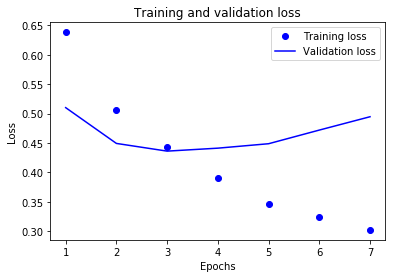

In [320]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

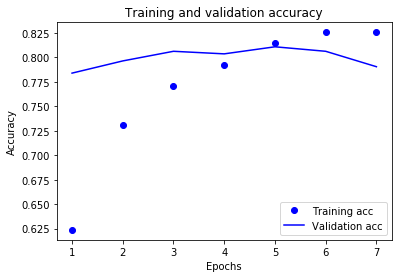

In [321]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [311]:
predict=model.predict(validation, batch_size=64)
print(predict)

[[0.96371037]
 [0.9728134 ]
 [0.98520166]
 ...
 [0.9960594 ]
 [0.9257151 ]
 [0.9768024 ]]


In [306]:
predict=np.round(predict).astype(int).reshape(3263)
sub=pd.DataFrame({'id':test['id'].values.tolist(),'target':predict})

In [307]:
sub.to_csv('DSKsubmission.csv', index=False)

/bin/sh: 1: kaggle: not found


In [0]:
import pandas as pd
sample_submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")
